# Bombcell Post-Run Analysis (Open Ephys + Kilosort4)

Assumes Bombcell has already been run and you exported per-probe CSV/JSON summaries.

**Expected folder convention**
- `{NP_recording_name}/bombcell_DEFAULT/`
  - `DUPLICATED_KILOSORT4_FILES/`
  - `batch_DEFAULT_results/`
- `{NP_recording_name}/bombcell_NP2.0/`
  - `DUPLICATED_KILOSORT4_FILES_ACD/`
  - `NP2_ReRun_results/`

In [1]:
NP_recording_name = 'Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00'

In [2]:
# New Code
from pathlib import Path

RECORDING_ROOT = Path(r"H:\Grant\Neuropixels\Kilosort_Recordings") / NP_recording_name

BOMBCELL_DEFAULT_ROOT = RECORDING_ROOT / 'bombcell' / "bombcell_DEFAULT"
BOMBCELL_NP20_ROOT = RECORDING_ROOT / 'bombcell'  / "bombcell_NP2.0"
BOMBCELL_SINGLEPROBE_ROOT = RECORDING_ROOT / "bombcell" / "bombcell_single_probe"


DEFAULT_KS_STAGING_ROOT = BOMBCELL_DEFAULT_ROOT 
NP20_KS_STAGING_ROOT = BOMBCELL_NP20_ROOT 
BOMBCELL_KS_SINGLEPROBE_STAGING_ROOT = BOMBCELL_SINGLEPROBE_ROOT 

DEFAULT_EXPORT_ROOT = BOMBCELL_DEFAULT_ROOT / "batch_DEFAULT_results"
NP20_EXPORT_ROOT = BOMBCELL_NP20_ROOT / "NP2_ReRun_results"
SINGLE_EXPORT_ROOT = BOMBCELL_SINGLEPROBE_ROOT / "single_probe_results"

# Make sure they exist
for p in [
    DEFAULT_KS_STAGING_ROOT,
    NP20_KS_STAGING_ROOT,
    BOMBCELL_KS_SINGLEPROBE_STAGING_ROOT,
    DEFAULT_EXPORT_ROOT,
    NP20_EXPORT_ROOT,
    SINGLE_EXPORT_ROOT

]:
    p.mkdir(parents=True, exist_ok=True)
    print('ALL Paths Exist')


ALL Paths Exist
ALL Paths Exist
ALL Paths Exist
ALL Paths Exist
ALL Paths Exist
ALL Paths Exist


In [3]:
# =========================
# Configure
# =========================
from pathlib import Path
import pandas as pd
import numpy as np
import json

PROBES_ALL  = ["A","B","C","D","E","F"]
PROBES_NP20 = ["A","C","D"]

print("RECORDING_ROOT:", RECORDING_ROOT)
print("DEFAULT_EXPORT_ROOT exists:", DEFAULT_EXPORT_ROOT.exists())
print(DEFAULT_EXPORT_ROOT)
print("NP20_EXPORT_ROOT exists:", NP20_EXPORT_ROOT.exists())
print(NP20_EXPORT_ROOT)
print("SINGLE_EXPORT_ROOT exists:", SINGLE_EXPORT_ROOT.exists())
print(SINGLE_EXPORT_ROOT)

RECORDING_ROOT: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00
DEFAULT_EXPORT_ROOT exists: True
H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\batch_DEFAULT_results
NP20_EXPORT_ROOT exists: True
H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_NP2.0\NP2_ReRun_results
SINGLE_EXPORT_ROOT exists: True
H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_single_probe\single_probe_results


In [4]:
# =========================
# Helpers
# =========================
def load_probe_exports(export_root: Path, probe: str):
    # Loads Probe_{probe} exports: quality_metrics.csv, unit_type_counts.csv, param.json, checks.json.
    probe_dir = export_root / f"Probe_{probe}"
    qm_path = probe_dir / f"Probe_{probe}_quality_metrics.csv"
    counts_path = probe_dir / f"Probe_{probe}_unit_type_counts.csv"
    param_path = probe_dir / f"Probe_{probe}_param.json"
    checks_path = probe_dir / f"Probe_{probe}_checks.json"
    err_path = probe_dir / "ERROR.txt"

    if err_path.exists():
        return {"probe": probe, "status": "FAILED", "error": err_path.read_text(), "probe_dir": probe_dir}

    out = {"probe": probe, "status": "OK", "probe_dir": probe_dir}
    out["qm"] = pd.read_csv(qm_path) if qm_path.exists() else None
    out["counts"] = pd.read_csv(counts_path) if counts_path.exists() else None
    out["param"] = json.loads(param_path.read_text()) if param_path.exists() else {}
    out["checks"] = json.loads(checks_path.read_text()) if checks_path.exists() else {}

    out["cluster_id_col"] = None

    out["ks_dir"] = out["checks"].get("ks_dir", None)
    out["save_path"] = out["checks"].get("save_path", None)
    
    if out["qm"] is not None:
        for c in ["cluster_id","clusterID","cluster_id_ks","cluster_id_phy","cluster"]:
            if c in out["qm"].columns:
                out["cluster_id_col"] = c
                break

    return out

def load_batch_summary(export_root: Path):
    p = export_root / "batch_summary.csv"
    return pd.read_csv(p) if p.exists() else None

def summarize_unit_types(qm: pd.DataFrame, label_col="Bombcell_unit_type"):
    if qm is None or label_col not in qm.columns:
        return None
    return qm[label_col].value_counts().rename_axis("unit_type").reset_index(name="count")

def add_percentages(df_counts: pd.DataFrame):
    if df_counts is None or df_counts.empty:
        return df_counts
    total = df_counts["count"].sum()
    df_counts = df_counts.copy()
    df_counts["pct"] = 100 * df_counts["count"] / total
    return df_counts

def find_cluster_row(qm: pd.DataFrame, cluster_id: int, cluster_id_col: str):
    if qm is None:
        raise ValueError("qm is None")
    if cluster_id_col is None or cluster_id_col not in qm.columns:
        raise ValueError("No cluster_id column found in quality_metrics.csv")
    sub = qm.loc[qm[cluster_id_col] == cluster_id]
    if sub.empty:
        raise KeyError(f"Cluster id {cluster_id} not found in {cluster_id_col}")
    return sub.iloc[0]

def threshold_fail_report(row, qm_cols, param):
    # Common Bombcell gates; only checks metrics that exist in the CSV.
    rules = [
        ("rawAmplitude", "<", param.get("minAmplitude", 40)),
        ("signalToNoiseRatio", "<", param.get("minSNR", 5)),
        ("presenceRatio", "<", param.get("minPresenceRatio", 0.7)),
        ("fractionRPVs_estimatedTauR", ">", param.get("maxRPVviolations", 0.1)),
        ("percentageSpikesMissing_gaussian", ">", param.get("maxPercSpikesMissing", 20)),
        ("waveformDuration_peakTrough", "<", param.get("minWvDuration", 100)),
        ("waveformDuration_peakTrough", ">", param.get("maxWvDuration", 1150)),
        ("nPeaks", ">", param.get("maxNPeaks", 2)),
        ("nTroughs", ">", param.get("maxNTroughs", 1)),
        ("waveformBaselineFlatness", ">", param.get("maxWvBaselineFraction", 0.3)),
    ]
    fails = []
    for col, op, thr in rules:
        if col not in qm_cols:
            continue
        v = row[col]
        if pd.isna(v):
            continue
        if (op == "<" and v < thr) or (op == ">" and v > thr):
            fails.append((col, float(v), op, float(thr)))
    return fails

## Load DEFAULT exports (all probes)

In [5]:
default_summary = load_batch_summary(DEFAULT_EXPORT_ROOT)
default_summary

,probe,status,ks_dir,save_path,n_NOISE,n_MUA,n_NON-SOMA,n_GOOD,max_raw_metric_nan_frac
0,A,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,392,109,51,2,0.012635
1,B,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,247,764,286,19,0.002280
2,C,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,154,135,30,36,0.014085
3,D,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,93,540,109,78,0.002439
4,E,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,100,394,251,119,0.008102
5,F,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,95,273,210,113,0.007236


## ==================================
## Check all probes and all BC session
## ==================================
- batch
- NP2.0 
- single probe

In [6]:
default_data = {p: load_probe_exports(DEFAULT_EXPORT_ROOT, p) for p in PROBES_ALL}

for p in PROBES_ALL:
    d = default_data[p]
    print("="*60, f"Probe {p} ({d['status']})")
    if d["status"] != "OK":
        print(d.get("error",""))
        continue
    counts = add_percentages(summarize_unit_types(d["qm"]))
    display(counts)

============================================================ Probe A (OK)


,unit_type,count,pct
0,NOISE,392,70.758123
1,MUA,109,19.675090
2,NON-SOMA,51,9.205776
3,GOOD,2,0.361011


============================================================ Probe B (OK)


,unit_type,count,pct
0,MUA,764,58.054711
1,NON-SOMA,286,21.732523
2,NOISE,247,18.768997
3,GOOD,19,1.443769


============================================================ Probe C (OK)


,unit_type,count,pct
0,NOISE,154,43.380282
1,MUA,135,38.028169
2,GOOD,36,10.140845
3,NON-SOMA,30,8.450704


============================================================ Probe D (OK)


,unit_type,count,pct
0,MUA,540,65.853659
1,NON-SOMA,109,13.292683
2,NOISE,93,11.341463
3,GOOD,78,9.512195


============================================================ Probe E (OK)


,unit_type,count,pct
0,MUA,394,45.601852
1,NON-SOMA,251,29.050926
2,GOOD,119,13.773148
3,NOISE,100,11.574074


============================================================ Probe F (OK)


,unit_type,count,pct
0,MUA,273,39.507959
1,NON-SOMA,210,30.390738
2,GOOD,113,16.353111
3,NOISE,95,13.748191


## Load NP2.0 rerun exports (A/C/D)

In [7]:
np20_summary = load_batch_summary(NP20_EXPORT_ROOT)
np20_summary

,probe,status,ks_dir,save_path,n_NOISE,n_MUA,n_NON-SOMA,n_GOOD,max_raw_metric_nan_frac,error
0,A,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,297.0,178.0,72.0,7.0,0.012635,NaN
1,C,OK,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,128.0,129.0,39.0,59.0,0.014085,NaN
2,D,FAILED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No quality_metrics found (unknown failure)


## Load NP2.0 Re-run results

In [8]:
np20_data = {p: load_probe_exports(NP20_EXPORT_ROOT, p) for p in PROBES_NP20}

for p in PROBES_NP20:
    d = np20_data[p]
    print("="*60, f"Probe {p} ({d['status']})")
    if d["status"] != "OK":
        print(d.get("error",""))
        continue
    counts = add_percentages(summarize_unit_types(d["qm"]))
    display(counts)

============================================================ Probe A (OK)


,unit_type,count,pct
0,NOISE,297,53.610108
1,MUA,178,32.129964
2,NON-SOMA,72,12.996390
3,GOOD,7,1.263538


============================================================ Probe C (OK)


,unit_type,count,pct
0,MUA,129,36.338028
1,NOISE,128,36.056338
2,GOOD,59,16.619718
3,NON-SOMA,39,10.985915


============================================================ Probe D (FAILED)
No quality_metrics found (unknown failure)


## Load single probe data

In [9]:
single_summary = load_batch_summary(SINGLE_EXPORT_ROOT)
single_summary

print(SINGLE_EXPORT_ROOT)

H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_single_probe\single_probe_results


In [10]:
single_probe_data = {p: load_probe_exports(SINGLE_EXPORT_ROOT, p) for p in PROBES_ALL}

for p in PROBES_ALL:
    d = single_probe_data[p]
    print("="*60, f"Probe {p} ({d['status']})")
    if d["status"] != "OK":
        print(d.get("error",""))
        continue
    counts = add_percentages(summarize_unit_types(d["qm"]))
    display(counts)

============================================================ Probe A (OK)


None

============================================================ Probe B (OK)


,unit_type,count,pct
0,MUA,747,56.762918
1,NON-SOMA,286,21.732523
2,NOISE,247,18.768997
3,GOOD,36,2.735562


============================================================ Probe C (OK)


None

============================================================ Probe D (OK)


None

============================================================ Probe E (OK)


None

============================================================ Probe F (OK)


None

## Compare DEFAULT vs Single rerun 

In [11]:
rows = []
for p in PROBES_ALL:
    d0 = default_data.get(p, {})
    d1 = single_probe_data.get(p, {})
    if d0.get("status") != "OK" or d1.get("status") != "OK":
        continue

    c0 = summarize_unit_types(d0["qm"])
    c1 = summarize_unit_types(d1["qm"])

    def _get(ct, name):
        if ct is None: 
            return 0
        sub = ct.loc[ct["unit_type"] == name, "count"]
        return int(sub.iloc[0]) if len(sub) else 0

    rows.append({
        "probe": p,
        "DEFAULT_GOOD": _get(c0,"GOOD"),
        "RERUN_GOOD": _get(c1,"GOOD"),
        "DEFAULT_MUA": _get(c0,"MUA"),
        "RERUN_MUA": _get(c1,"MUA"),
        "DEFAULT_NOISE": _get(c0,"NOISE"),
        "RERUN_NOISE": _get(c1,"NOISE"),
        "DEFAULT_NON-SOMA": _get(c0,"NON-SOMA"),
        "RERUN_NON-SOMA": _get(c1,"NON-SOMA"),
        "DEFAULT_TOTAL": len(d0["qm"]),
        # "RERUN_TOTAL": len(d1["qm"]),
    })
pd.DataFrame(rows)

,probe,DEFAULT_GOOD,RERUN_GOOD,DEFAULT_MUA,RERUN_MUA,DEFAULT_NOISE,RERUN_NOISE,DEFAULT_NON-SOMA,RERUN_NON-SOMA,DEFAULT_TOTAL
0,A,2,0,109,0,392,0,51,0,554
1,B,19,36,764,747,247,247,286,286,1316
2,C,36,0,135,0,154,0,30,0,355
3,D,78,0,540,0,93,0,109,0,820
4,E,119,0,394,0,100,0,251,0,864
5,F,113,0,273,0,95,0,210,0,691


## Compare DEFAULT vs NP2.0 rerun (A/C/D)

In [12]:
rows = []
for p in PROBES_NP20:
    d0 = default_data.get(p, {})
    d1 = np20_data.get(p, {})
    if d0.get("status") != "OK" or d1.get("status") != "OK":
        continue

    c0 = summarize_unit_types(d0["qm"])
    c1 = summarize_unit_types(d1["qm"])

    def _get(ct, name):
        if ct is None: 
            return 0
        sub = ct.loc[ct["unit_type"] == name, "count"]
        return int(sub.iloc[0]) if len(sub) else 0

    rows.append({
        "probe": p,
        "DEFAULT_GOOD": _get(c0,"GOOD"),
        "RERUN_GOOD": _get(c1,"GOOD"),
        "DEFAULT_MUA": _get(c0,"MUA"),
        "RERUN_MUA": _get(c1,"MUA"),
        "DEFAULT_NOISE": _get(c0,"NOISE"),
        "RERUN_NOISE": _get(c1,"NOISE"),
        "DEFAULT_NON-SOMA": _get(c0,"NON-SOMA"),
        "RERUN_NON-SOMA": _get(c1,"NON-SOMA"),
        "DEFAULT_TOTAL": len(d0["qm"]),
        "RERUN_TOTAL": len(d1["qm"]),
    })
pd.DataFrame(rows)

,probe,DEFAULT_GOOD,RERUN_GOOD,DEFAULT_MUA,RERUN_MUA,DEFAULT_NOISE,RERUN_NOISE,DEFAULT_NON-SOMA,RERUN_NON-SOMA,DEFAULT_TOTAL,RERUN_TOTAL
0,A,2,7,109,178,392,297,51,72,554,554
1,C,36,59,135,129,154,128,30,39,355,355


## ==================================
## Check single units from single BC sessions
## ==================================


#### Options for BC_SESSION

In [15]:
BOMBCELL_DEFAULT_ROOT = RECORDING_ROOT / 'bombcell' / "bombcell_DEFAULT"
BOMBCELL_NP20_ROOT = RECORDING_ROOT / 'bombcell'  / "bombcell_NP2.0"
BOMBCELL_SINGLEPROBE_ROOT = RECORDING_ROOT / "bombcell" / "bombcell_single_probe"


### SET the following
1. Probe Letter = 'A', 'B', 'C', 'D', 'E', 'F'
2. BC_SESSION = BOMBCELL_DEFAULT_ROOT / BOMBCELL_NP20_ROOT / BOMBCELL_SINGLEPROBE_ROOT
3. cluster_id = specific unit to check

In [41]:
probe = "B"      
cluster_id = 39     # AKA. unitID from kilosort    

run = "SINGLE"      # "DEFAULT" or "NP20" or 'SINGLE'
BC_SESSION = BOMBCELL_SINGLEPROBE_ROOT # BOMBCELL_DEFAULT_ROOT or BOMBCELL_NP20_ROOT or BOMBCELL_SINGLEPROBE_ROOT


In [42]:
ks_dir = Path(fr"{BC_SESSION}\kilosort4_{probe}")

if ks_dir.exists():
    print(f'Found BC session for probe {probe}')
    print(ks_dir)
else:
    print('No Dir Found')


Found BC session for probe B
H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_single_probe\kilosort4_B


In [43]:
from pathlib import Path
import pandas as pd



label_tsv = ks_dir / "cluster_bc_unitType.tsv"
df = pd.read_csv(label_tsv, sep="\t")

# Column is usually 'cluster_id' or 'id'
print(df.columns)

# Try both common names:
if "cluster_id" in df.columns:
    print('cluster_id Found')
    print(df.loc[df["cluster_id"] == cluster_id])
elif "id" in df.columns:
    print(df.loc[df["id"] == cluster_id])
else:
    raise ValueError("Unexpected columns; print(df.head()) and inspect.")


Index(['cluster_id', 'bc_unitType'], dtype='str')
cluster_id Found
    cluster_id bc_unitType
39          39        GOOD


## Drill-down: why Bombcell labeled a specific cluster as MUA (or not GOOD)

This reports which thresholds are violated for a chosen `probe` and `cluster_id`.

In [44]:
if run == "DEFAULT":
    print('=== About to Analyze ====')
    print(run, 'BC Session run')
    print()
    d = default_data[probe] 
if run == "NP20":
    print('=== About to Analyze ====')
    print(run, 'BC Session run')

    print()
    d = np20_data[probe] 
if run == "SINGLE":
    print('=== About to Analyze ====')
    print(run, 'BC Session run')
    d = single_probe_data[probe] 


=== About to Analyze ====
SINGLE BC Session run


#### Load in following results data
1. quality metrics
2. params 

In [45]:
# load CSV
quality_metrics_path = Path(fr"H:\Grant\Neuropixels\Kilosort_Recordings\{NP_recording_name}\bombcell\bombcell_single_probe\single_probe_results\Probe_{probe}\Probe_{probe}_quality_metrics.csv")
df = pd.read_csv(quality_metrics_path)
# print just the row for cluster_id
df_unit = df[df['phy_clusterID'] == cluster_id]
df_unit

params_json_path = Path(fr"H:\Grant\Neuropixels\Kilosort_Recordings\{NP_recording_name}\bombcell\bombcell_single_probe\single_probe_results\Probe_{probe}\Probe_{probe}_param.json")
# load params.json
with open(params_json_path, 'r') as f:
    params = json.load(f)

if quality_metrics_path.exists():
    print('Quality Metrics Existis')
else:
    print('NO Quality Metrics')

if params_json_path.exists():
    print('Params JSON Exists')
else:
    print('NO Params JSON')

Quality Metrics Existis
Params JSON Exists


### Save out the Quality Metrics Row for the single unit your looking at

In [46]:
# Save CSV
output_path = fr"H:\Grant\Neuropixels\Kilosort_Recordings\{NP_recording_name}\bombcell\bombcell_single_probe\single_probe_results\Probe_{probe}\Probe_{probe}_unit_{cluster_id}_quality_metrics.csv"
df_unit.to_csv(output_path, index=False)
print(f"Saved unit quality metrics to: {output_path}")

Saved unit quality metrics to: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_single_probe\single_probe_results\Probe_B\Probe_B_unit_39_quality_metrics.csv


### Check the parameters used by Bombcell on this specific run

In [47]:
params

{'plotDetails': False,
 'plotGlobal': True,
 'savePlots': False,
 'plotsSaveDir': None,
 'verbose': True,
 'reextractRaw': False,
 'saveAsTSV': True,
 'unit_type_for_phy': True,
 'ephysKilosortPath': 'H:\\Grant\\Neuropixels\\Kilosort_Recordings\\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\\bombcell\\bombcell_single_probe\\kilosort4_B',
 'removeDuplicateSpikes': False,
 'duplicateSpikeWindow_s': 3.4e-05,
 'saveSpikes_withoutDuplicates': True,
 'recomputeDuplicateSpikes': False,
 'detrendWaveform': True,
 'detrendForUnitMatch': False,
 'nRawSpikesToExtract': 100,
 'decompress_data': False,
 'extractRaw': True,
 'probeType': 1,
 'tauR_valuesMin': 0.0005,
 'tauR_valuesMax': 0.002,
 'tauR_valuesStep': 0.0005,
 'tauC': 0.0001,
 'hillOrLlobetMethod': True,
 'computeTimeChunks': True,
 'deltaTimeChunk': 360,
 'presenceRatioBinSize': 120,
 'driftBinSize': 60,
 'computeDrift': False,
 'minThreshDetectPeaksTroughs': 0.2,
 'normalizeSpDecay': True,
 'spDecayLinFit': False

In [49]:
single_probe_data = {p: load_probe_exports(SINGLE_EXPORT_ROOT, p) for p in PROBES_ALL}

for p in PROBES_ALL:
    d = single_probe_data[p]
    print("="*60, f"Probe {p} ({d['status']})")
    if d["status"] != "OK":
        print(d.get("error",""))
        continue
    counts = add_percentages(summarize_unit_types(d["qm"]))
    display(counts)

============================================================ Probe A (OK)


None

============================================================ Probe B (OK)


,unit_type,count,pct
0,GOOD,425,32.294833
1,MUA,358,27.203647
2,NON-SOMA,286,21.732523
3,NOISE,247,18.768997


============================================================ Probe C (OK)


None

============================================================ Probe D (OK)


None

============================================================ Probe E (OK)


None

============================================================ Probe F (OK)


None

In [48]:
# =========================
# Old code
# if run == "DEFAULT":
#     d = default_data[probe]
# if run == "NP20":
#     d = np20_data[probe]
# if run == "SINGLE":
#     d = single_probe_data[probe]
# ...
# row = find_cluster_row(qm,cluster_id,cluster_id_col)   # fails when cluster_id missing
# =========================

# =========================
# New Code
# =========================
from pathlib import Path  # New Code
import pandas as pd       # New Code
import numpy as np        # New Code

# --- Select dataset ---
if run == "DEFAULT":  # New Code
    d = default_data[probe]  # New Code
elif run == "NP20":  # New Code
    d = np20_data[probe]  # New Code
elif run == "SINGLE":  # New Code
    d = single_probe_data[probe]  # New Code
else:  # New Code
    raise ValueError("run must be one of: 'DEFAULT', 'NP20', 'SINGLE'")  # New Code

qm = d["qm"]  # New Code
param = d["param"]  # New Code

print("Run:", run)  # New Code
print("Probe:", probe)  # New Code

# --- Ensure cluster_id exists for drill-down ---
cluster_id_col = d.get("cluster_id_col", None)  # New Code

if cluster_id_col is None or cluster_id_col not in qm.columns:  # New Code
    from pathlib import Path  # New Code

    ks_dir = Path(d.get("ks_dir", ""))  # New Code

    # If ks_dir is stale/missing the "\bombcell\" folder, rewrite it.
    if not ks_dir.exists():  # New Code
        s = str(ks_dir)  # New Code
        if "\\bombcell_single_probe\\" in s and "\\bombcell\\bombcell_single_probe\\" not in s:  # New Code
            ks_dir = Path(s.replace("\\bombcell_single_probe\\", "\\bombcell\\bombcell_single_probe\\"))  # New Code

    # Hard fail if still missing
    if not ks_dir.exists():  # New Code
        raise FileNotFoundError(f"ks_dir does not exist (even after rewrite): {ks_dir}")  # New Code

    # Update d so downstream code uses the corrected path
    d["ks_dir"] = str(ks_dir)  # New Code
    cluster_id_col = "cluster_id" if "cluster_id" in d.get("qm", pd.DataFrame()).columns else d.get("cluster_id_col", None)  # New Code

    print("Using ks_dir:", ks_dir)  # New Code

    label_tsv = ks_dir / "cluster_bc_unitType.tsv"  # New Code

    if not ks_dir.exists():  # New Code
        raise FileNotFoundError(f"Missing d['ks_dir'] or path does not exist: {ks_dir}")  # New Code
    if not label_tsv.exists():  # New Code
        raise FileNotFoundError(f"Missing cluster_bc_unitType.tsv at: {label_tsv}")  # New Code

    lab = pd.read_csv(label_tsv, sep="\t")  # New Code
    if "cluster_id" not in lab.columns:  # New Code
        raise ValueError(f"cluster_bc_unitType.tsv has no 'cluster_id'. Columns: {list(lab.columns)}")  # New Code

    # Attach cluster_id by row order (best available if cluster_info.tsv was not exported)
    cluster_ids = lab["cluster_id"].to_numpy().astype(int)  # New Code
    if len(cluster_ids) != len(qm):  # New Code
        raise ValueError(f"Length mismatch: qm={len(qm)} vs TSV={len(cluster_ids)}; cannot attach cluster_id safely.")  # New Code

    qm = qm.copy()  # New Code
    qm.insert(0, "cluster_id", cluster_ids)  # New Code
    cluster_id_col = "cluster_id"  # New Code

# --- Fetch the row and report ---
row = find_cluster_row(qm, cluster_id, cluster_id_col)  # New Code
print("Bombcell label:", row.get("Bombcell_unit_type", "UNKNOWN"))  # New Code

fails = threshold_fail_report(row, qm.columns, param)  # New Code

print("\n---- FAILING GATES ----")  # New Code
if not fails:  # New Code
    print("No fails among common checks; expand rules or inspect full row.")  # New Code
else:  # New Code
    for col, v, op, thr in fails:  # New Code
        print(f"{col:35s} {v:>10.4f}  FAIL ({op}{thr})")  # New Code

print("\n---- Key values ----")  # New Code
key_cols = [  # New Code
    "rawAmplitude", "signalToNoiseRatio", "presenceRatio",
    "fractionRPVs_estimatedTauR", "percentageSpikesMissing_gaussian",
    "waveformDuration_peakTrough", "nPeaks", "nTroughs", "waveformBaselineFlatness"
]  # New Code
for c in key_cols:  # New Code
    if c in qm.columns:  # New Code
        print(f"{c:35s} {row[c]}")  # New Code


Run: SINGLE
Probe: B
Using ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_single_probe\kilosort4_B
Bombcell label: MUA

---- FAILING GATES ----
fractionRPVs_estimatedTauR              1.0000  FAIL (>0.2)

---- Key values ----
rawAmplitude                        67.69393310399225
signalToNoiseRatio                  13.139364834336382
presenceRatio                       0.948051948051948
fractionRPVs_estimatedTauR          1.0
percentageSpikesMissing_gaussian    4.309610609595138
waveformDuration_peakTrough         166.66666666666666
nPeaks                              1.0
nTroughs                            1.0
waveformBaselineFlatness            0.008860370144248


## Distributions (RPV, presenceRatio)

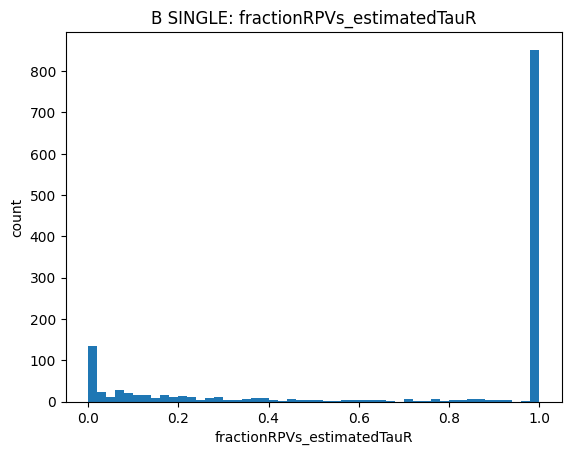

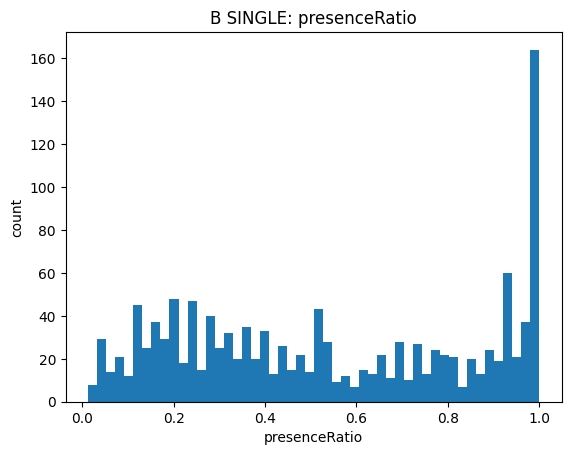

In [24]:
import matplotlib.pyplot as plt

# --- Select dataset ---
if run == "DEFAULT":  # New Code
    d = default_data[probe]  # New Code
elif run == "NP20":  # New Code
    d = np20_data[probe]  # New Code
elif run == "SINGLE":  # New Code
    d = single_probe_data[probe]  # New Code
else:  # New Code
    raise ValueError("run must be one of: 'DEFAULT', 'NP20', 'SINGLE'")  # New Code
qm = d["qm"]

for col in ["fractionRPVs_estimatedTauR", "presenceRatio"]:
    if col in qm.columns:
        plt.figure()
        plt.hist(qm[col].dropna(), bins=50)
        plt.title(f"{probe} {run}: {col}")
        plt.xlabel(col); plt.ylabel("count")
        plt.show()

## Metric-by-label medians

In [26]:
# --- Select dataset ---
if run == "DEFAULT":  # New Code
    d = default_data[probe]  # New Code
elif run == "NP20":  # New Code
    d = np20_data[probe]  # New Code
elif run == "SINGLE":  # New Code
    d = single_probe_data[probe]  # New Code
else:  # New Code
    raise ValueError("run must be one of: 'DEFAULT', 'NP20', 'SINGLE'")  # New Code
qm = d["qm"]

metrics = ["fractionRPVs_estimatedTauR","presenceRatio","rawAmplitude","signalToNoiseRatio"]
present = [m for m in metrics if m in qm.columns]
qm.groupby("Bombcell_unit_type")[present].median()

,fractionRPVs_estimatedTauR,presenceRatio,rawAmplitude,signalToNoiseRatio
Bombcell_unit_type,,,,
GOOD,0.079324,0.798701,71.149292,17.631865
MUA,1.000000,0.454545,84.813284,21.137498
NOISE,1.000000,0.766234,99.970672,18.332119
NON-SOMA,1.000000,0.454545,51.848578,12.032534


## Compact overview table

In [27]:
def overview_table(data_dict: dict):
    rows = []
    for p, d in data_dict.items():
        if d.get("status") != "OK":
            rows.append({"probe": p, "status": "FAILED"})
            continue
        qm = d["qm"]
        counts = qm["Bombcell_unit_type"].value_counts()
        total = len(qm)
        row = {
            "probe": p,
            "status": "OK",
            "n_total": int(total),
            "n_GOOD": int(counts.get("GOOD",0)),
            "pct_GOOD": 100*float(counts.get("GOOD",0))/total if total else np.nan,
        }
        for m in ["fractionRPVs_estimatedTauR","presenceRatio","rawAmplitude","signalToNoiseRatio"]:
            if m in qm.columns:
                row[f"median_{m}"] = float(qm[m].median())
        rows.append(row)
    return pd.DataFrame(rows)

default_overview = overview_table(default_data)
np20_overview = overview_table(np20_data)
single_overview = overview_table(single_probe_data)

print("DEFAULT overview")
display(default_overview.sort_values("probe"))

print("NP2.0 rerun overview")
display(np20_overview.sort_values("probe"))

print("SINGLE probe overview")
display(single_overview.sort_values("probe"))


TypeError: 'NoneType' object is not subscriptable

## Checking fractionRPVs_estimatedTauR

In [28]:
from pathlib import Path  # New Code
import pandas as pd       # New Code
import numpy as np        # New Code

# --- Select dataset ---
if run == "DEFAULT":  # New Code
    d = default_data[probe]  # New Code
elif run == "NP20":  # New Code
    d = np20_data[probe]  # New Code
elif run == "SINGLE":  # New Code
    d = single_probe_data[probe]  # New Code
else:  # New Code
    raise ValueError("run must be one of: 'DEFAULT', 'NP20', 'SINGLE'")  # New Code

qm = d["qm"]  # New Code
param = d["param"]  # New Code

print("Run:", run)  # New Code
print("Probe:", probe)  # New Code

# --- Ensure cluster_id exists for drill-down ---
cluster_id_col = d.get("cluster_id_col", None)  # New Code

if cluster_id_col is None or cluster_id_col not in qm.columns:  # New Code
    from pathlib import Path  # New Code

    ks_dir = Path(d.get("ks_dir", ""))  # New Code

    # If ks_dir is stale/missing the "\bombcell\" folder, rewrite it.
    if not ks_dir.exists():  # New Code
        s = str(ks_dir)  # New Code
        if "\\bombcell_single_probe\\" in s and "\\bombcell\\bombcell_single_probe\\" not in s:  # New Code
            ks_dir = Path(s.replace("\\bombcell_single_probe\\", "\\bombcell\\bombcell_single_probe\\"))  # New Code

    # Hard fail if still missing
    if not ks_dir.exists():  # New Code
        raise FileNotFoundError(f"ks_dir does not exist (even after rewrite): {ks_dir}")  # New Code

Run: SINGLE
Probe: B


In [31]:
import numpy as np
from pathlib import Path

# ============================
# USER INPUT
# ============================
ks_dir = ks_dir
unit_id = 39  # Unit to inspect
# ============================


print("Analyzing BC Session:", run)  # New Code
print("Probe Being Analyzed:", probe)  # New Code
print('unit being analyzed: ', unit_id)
print('==========================')
print('')

# Load Kilosort outputs
spike_times = np.load(ks_dir / "spike_times.npy").squeeze()
spike_clusters = np.load(ks_dir / "spike_clusters.npy").squeeze()

# Extract spikes for unit
unit_spike_times = spike_times[spike_clusters == unit_id]

print(f"Total spikes for unit {unit_id}: {len(unit_spike_times)}")

# Check monotonicity
is_monotonic = np.all(np.diff(unit_spike_times) >= 0)
print(f"Spike times monotonic increasing: {is_monotonic}")

# Compute ISIs (in samples)
isi = np.diff(unit_spike_times)

# Exact duplicate timestamps (0 sample ISI)
n_zero_isi = np.sum(isi == 0)
print(f"Number of zero-ISI events (exact duplicates): {n_zero_isi}")

# ISIs < 1 sample (should not exist)
n_subsample_isi = np.sum(isi < 0)
print(f"Number of negative ISIs: {n_subsample_isi}")

# Unique spike count
n_unique = len(np.unique(unit_spike_times))
print(f"Unique spike timestamps: {n_unique}")
print(f"Duplicate timestamps: {len(unit_spike_times) - n_unique}")

# Fraction of duplicate spikes
if len(unit_spike_times) > 0:
    frac_duplicates = (len(unit_spike_times) - n_unique) / len(unit_spike_times)
    print(f"Fraction duplicates: {frac_duplicates:.6f}")\

# --- New Code: verify sampling rate and compute simple RPV fractions ---
fs = None  # New Code
for candidate in ["ops.npy", "params.npy"]:  # New Code
    p = ks_dir / candidate  # New Code
    if p.exists():  # New Code
        ops = np.load(p, allow_pickle=True).item()  # New Code
        fs = ops.get("fs", None)  # New Code
        if fs is not None:  # New Code
            break  # New Code

print(f"Detected fs: {fs}")  # New Code
if fs is None:  # New Code
    raise FileNotFoundError("Could not find fs in ops.npy/params.npy. Inspect your Kilosort folder for where fs is stored.")  # New Code

# ISIs in samples and seconds  # New Code
isi_samp = np.diff(unit_spike_times)  # New Code
isi_sec = isi_samp / fs  # New Code

# Plain RPV fractions at canonical refractory windows  # New Code
for r_ms in [0.5, 1.0, 1.5, 2.0]:  # New Code
    r = r_ms / 1000.0  # New Code
    frac = np.mean(isi_sec < r) if len(isi_sec) else np.nan  # New Code
    print(f"Plain RPV fraction (ISI < {r_ms:.1f} ms): {frac:.6f}")  # New Code

# Sanity: report firing rate estimate  # New Code
dur_sec = (unit_spike_times[-1] - unit_spike_times[0]) / fs if len(unit_spike_times) > 1 else np.nan  # New Code
rate_hz = len(unit_spike_times) / dur_sec if dur_sec and dur_sec > 0 else np.nan  # New Code
print(f"Approx duration (sec): {dur_sec:.2f} | mean rate (Hz): {rate_hz:.2f}")  # New Code


Analyzing BC Session: SINGLE
Probe Being Analyzed: B
unit being analyzed:  39

Total spikes for unit 39: 115739
Spike times monotonic increasing: True
Number of zero-ISI events (exact duplicates): 0
Number of negative ISIs: 0
Unique spike timestamps: 115739
Duplicate timestamps: 0
Fraction duplicates: 0.000000
Detected fs: 30000
Plain RPV fraction (ISI < 0.5 ms): 0.000657
Plain RPV fraction (ISI < 1.0 ms): 0.003076
Plain RPV fraction (ISI < 1.5 ms): 0.009599
Plain RPV fraction (ISI < 2.0 ms): 0.019147
Approx duration (sec): 9289.63 | mean rate (Hz): 12.46
